In [2]:
from bs4 import BeautifulSoup
import requests
from pprint import pprint
import json, itertools
from collections import Counter
import re
import numpy as np

def get_soup(url):
    return BeautifulSoup(requests.get(url).text, 'lxml')

def get_library(url):
    pages = max([
        int(li.find("a")["href"].split("page=")[1])
        for li in get_soup(url).find_all("li", {"class": "page"})
        if li.find("a") is not None and li.find("a")["href"] is not None
    ])
    
    books = {}
    for page in range(pages):
        books.update({
            div.find("a").text: div.find("a")["href"]
            for div in (
                get_soup((url + "?page={page}").format(page=page+1))
                  .find_all("div", {"class": "vcWrapA titleBox"})
            )
        })
    return books

def get_book(url):
    pages = max([1] + [
        int(li.find("a")["href"].split("page=")[1])
        for li in get_soup(url).find_all("li", {"class": "page"})
        if li.find("a") is not None and li.find("a")["href"] is not None
    ])
    text = ""
    for page in range(pages):
        text += get_soup((url + "?page={page}").format(page=page+1)).find("div", {"id": "pageText"}).text
    return text

class FrequencyDictionary:
    def __init__(self, samples):
        self.freqs = dict(Counter([
            self.extract_stem(w)
            for w in self.split_text(" ".join(samples))
            if len(self.extract_stem(w)) > 0
        ]))
        self.freqs[""] = np.inf
        total = sum(self.freqs.values())
        self.freqs = {k:v/total for k, v in self.freqs.items()}
        
    def split_text(self, text):
        return re.split(r"\s+", re.sub(r"[\"\',.?!\u00bb\u00ab\-\(\)\—:]", "", text))
        
    def __getitem__(self, word):
        return self.freqs.get(self.extract_stem(word), 0)

    def extract_stem(self, word):
        raise NotImplementedError("Need to subclass FrequencyDictionary per language")
        
    def average_frequency(self, text):
        return np.mean([self.__getitem__(w) for w in self.split_text(text)])
    
    def hard_words(self, text, n_words=10):
        return list(zip(*sorted(
            list(set(
                (self.__getitem__(w), self.extract_stem(w))
                for w in self.split_text(text)
            ))
        )))[1][:n_words]

class LatvianFD(FrequencyDictionary):
    def extract_stem(self, word):
        word = word.lower()
        prefixes = [
            'a(.*)', 'aiz(.*)', 'ap(.*)', 'at(.*)',
            'homo(.*)', 'ie(.*)', 'iz(.*)', 'jota(.*)',
            'mikro(.*)', 'ne(.*)', 'no(.*)', 'pa(.*)',
            'pie(.*)', 'prie(.*)', 'priekš(.*)', 'proto(.*)',
            'pār(.*)', 'sa(.*)', 'uz(.*)'
        ]
        for p in prefixes:
            m = re.match(p, word)
            if m:
                word = m.group(1)
        return word

In [4]:
try:
    with open("library.json") as f:
        books = json.loads(f.read())
except:
    library = get_library("http://www.pasakas.net/pasakas/latviesu-pasakas/")
    books = {
        title: {
            "source": link,
            "text": get_book(link)
        }
        for title, link in library.items()
    }
    with open("library.json", "w") as f:
        f.write(json.dumps(books, indent=4))

In [5]:
fd = LatvianFD([book["text"] for title, book in books.items()])

with open("vocab.json", "w") as f:
    f.write(json.dumps(fd.freqs))

books = {
    title: {
        **book,
        "average_frequency": fd.average_frequency(book["text"]),
        "hard_words": fd.hard_words(book["text"])
    }
    for title, book in books.items()
}
pprint(books)

{' Tirgotāja meita': {'average_frequency': nan,
                      'difficulty': -0.003492151396756476,
                      'hard_words': ('auguši',
                                     'beidzot',
                                     'bez',
                                     'bijis',
                                     'bildina',
                                     'brālim',
                                     'brālīši',
                                     'cietums',
                                     'cietumā',
                                     'cilvēks'),
                      'source': 'http://www.pasakas.net/pasakas/latviesu-pasakas/dzukstes_pasakas/t/tirgotaja_meita/',
                      'text': 'Kādam tirgotajam bijuši divi pieauguši bērni: '
                              'dēls un meita. Reiz tirgotajam jābūt uz ilgāku '
                              'laiku citā pilsētā. Kur nu pa to laiku abus '
                              'bērnus atstāt? Sieva tam miruse un

                               'savu sieviņu, aizgāja uz savu iedāvināto '
                               'valsti par ķēniņu un dzīvoja laimīgi.\n'
                               '\n'
                               '\n'
                               '  \xa0\xa0\xa0Arī savu audžu tēvu un sievas '
                               'māti tas pieņēma. Un vēlāk, caur sievas mātes '
                               'stāstīšanu, saklaušināja pat savu īsto tēvu. '
                               'Tas iesākumā negribēja nemaz ticēt, ka viņa '
                               'dēls dzīvs un pie tam vēl par ķēniņu.\n'},
 'Attapīgais puisis': {'average_frequency': nan,
                       'difficulty': -0.0031135906617445054,
                       'hard_words': ('bailes',
                                      'beidza',
                                      'beidzamo',
                                      'bijis',
                                      'briesmīgi',
                                    

                                           'izmanīties. Paņemiet rītu '
                                           'cirvi,"viņa teica, "un liekaties '
                                           'uz staļļa sliekšņa kaut ko tēst - '
                                           'ķēve prasīs: "Kur liksi to, ko '
                                           'tēs?"tad atbildiet, ka "aizķīlēšot '
                                           'šai purnu, lai nevarētu tā '
                                           'rīt."Ķēve palikšot tūliņ '
                                           'mierīga."\n'
                                           '\n'
                                           '\n'
                                           '  \xa0\xa0\xa0"Princis, no rīta '
                                           'stallī iegājis, nolika ķēvei sienu '
                                           'priekšā, bet nedabūja ne nost '
                                           'atnākt, ka jau tas bija aprīts un '

                          'izteicis tam. Mācītājs ņēmis apsvētīt veco '
                          'jaunekli, bet līdz ko apsvētījis, tā jauneklis '
                          'palicis par pelnu čupiņu.\n'},
 'Dzērājs par ķēniņu': {'average_frequency': nan,
                        'difficulty': -0.0036815349921645074,
                        'hard_words': ('3',
                                       'bažām',
                                       'beidzot',
                                       'bijis',
                                       'blandīties',
                                       'brašas',
                                       'brīža',
                                       'bērzu',
                                       'būdiņas',
                                       'būdiņu'),
                        'source': 'http://www.pasakas.net/pasakas/latviesu-pasakas/latviesu_tautas_pasakas/d/dzerajs-par-keninu/',
                        'text': '\n'
                          

                            '\n'
                            '\n'
                            '\xa0\xa0\xa0Reiz, labi nostrādājies, saimnieks '
                            'sacīja kalpam:\n'
                            '\n'
                            '\n'
                            '\xa0\xa0\xa0- Man gribas ēst!\n'
                            '  \xa0\xa0\xa0Bet kalps atteica:\n'
                            '\n'
                            '\n'
                            '\xa0\xa0\xa0- Brīnums, man vēl nemaz negribas.\n'
                            '\n'
                            '\n'
                            '\xa0\xa0\xa0- Kā tad tas nākas? — vaicā '
                            'saimnieks.\n'
                            '\n'
                            '\n'
                            '\xa0\xa0\xa0- Es, — atbild kalps, — saēdos '
                            'brangas garozas: kamēr garozas vēderā neizmirkst, '
                            'tikmēr ēst negribas.\n'
                 

                                       'cienījamais',
                                       'citi'),
                        'source': 'http://www.pasakas.net/pasakas/latviesu-pasakas/latviesu_tautas_pasakas/k/kungs-dabu-perienu/',
                        'text': '\n'
                                'Viens kungs bija dzirdējis, ka daudz kūlēju '
                                'pa kuļamo laiku tik šurp un turp nolodājot un '
                                'noguļot. Reiz viņš aizgāja pats uz riju '
                                'noskatīties un ielīda nemanot palievenī '
                                'salmos, kamēr strādnieki taisījās uz kulšanu. '
                                'Viens strādnieks tomēr to redzēja un pateica '
                                'rijniekam. Šim tūdaļ iekrita prātā bargo '
                                'kungu brangi pārmācīt. Kādam kūlējam viņš '
                                'paklusām ieteica, lai nolien kaut kur projām. '
                         

                                                  'vienreiz zvērs atstiepjas. '
                                                  'Līdz ko tas padarīts, te '
                                                  'zirgs bez saukšanas klāt, '
                                                  'sacīdams: "Tas labi, ka '
                                                  'izdevās. Tagad vel zvēru '
                                                  'ratos un brauksim otram '
                                                  'mežam cauri. Tur būs avots '
                                                  'un aiz avota liels dārzs ar '
                                                  'augstu, augstu sētu. Zvērs '
                                                  'mums ar avota ūdeni '
                                                  'jāatdzīvina un tad jāielaiž '
                                                  'dārzā - tur zelta zirgs '
                                                  'atronas.

 'Meitene ar vilku': {'average_frequency': nan,
                      'difficulty': -0.003538838182801031,
                      'hard_words': ('atlika',
                                     'augušies',
                                     'bagāta',
                                     'bagātam',
                                     'bet',
                                     'bija',
                                     'bijis',
                                     'bijusi',
                                     'braucis',
                                     'bruka'),
                      'source': 'http://www.pasakas.net/pasakas/latviesu-pasakas/latviesu_tautas_pasakas/m/meitene-ar-vilku/',
                      'text': '\n'
                              'Vienam bagātam saimniekam bijusi īstā meita un '
                              'pameita. Īstā meita, kā jau parasts, nekā daudz '
                              'nestrādāja. Pameitai turpretim bija jāiet visos '
                     

                                  '\xa0\xa0\xa0Bet būrītis bijis ar smalku '
                                  'zelta stīgu pie ķēniņa gultas '
                                  'piestiprināts. Līdzko šis nu būrīti ņem, te '
                                  'ķēniņš atmostas un liek saviem sargiem '
                                  'ņēmēju saķert. Par sodu ķēniņš uzliek '
                                  'muļķītim tādu zirgu atvest, kam sudraba '
                                  'spalva, zelta krēpes. Te nu bija - būrīti '
                                  'ņemdams, dabūja pie meklētā vēl meklējamo '
                                  'klāt.\n'
                                  '\xa0\xa0\xa0Noiet pie vilka. Vilks rājas:\n'
                                  '\n'
                                  '\xa0\xa0«Vai tev neteicu, lai būrīti neņem! '
                                  'Kāp mugurā, aiznesīšu tur, kur tas zirgs '
                                  'ir. Tas zirgs būs patīkams, iema

                                     '\n'
                                     '\n'
                                     '\xa0\xa0\xa0«Nācu, šāvējs, - vai sašausi '
                                     'vienā šāvienā visas piecas?»\n'
                                     '\n'
                                     '\xa0\xa0\xa0Šāvējs vēro, vēro - te uz '
                                     'reizi knaukt: visas piecas pušu.\n'
                                     '\n'
                                     '\n'
                                     '\xa0\xa0\xa0«Tas labi!» tēvs '
                                     'nopriecājas.\n'
                                     '\n'
                                     '\n'
                                     '\xa0\xa0\xa0«Bet vai tu, šuvēj, varēsi '
                                     'sašūt?»\n'
                                     '\n'
                                     '\n'
                                     '\xa0\xa0\xa0Šuvējs sāk strādāt

                              'domās: «Žēl būtu tādu pārgalvnieku atsvabināt, '
                              'bet meitas dēļ taču būs jālaiž.»\n'
                              '\n'
                              '\n'
                              '  \xa0\xa0\xa0Izlaiž koklētāju - vai zinot '
                              'princesi atrast? Varbūt gan! Lai tikai padodot '
                              'laivu. Prasi, kā šis nezinās, kad skaidri '
                              'redzējis. Aizbrauc pie salas — jā, princese '
                              'iznāk pretim sveika, vesela. Abi iesēžas laivā '
                              'un brauc pie tēva.\n'
                              '\n'
                              '\n'
                              '  \xa0\xa0\xa0Tagad ķēniņam bija jādod meita '
                              'koklētājam, vai grib vai negrib.\n'},
 'Septiņi apburtie brāļi': {'average_frequency': nan,
                            'difficulty': -0.00340217792693354,
       

                                       '\n'
                                       '\n'
                                       '  Arī Lullai sāka drebēt rokas. '
                                       'Mazais, mīļais rūķu bērns tik šausmīgu '
                                       'nelaimi piedzīvojis, pie visa vainīgs '
                                       'briesmonis Cūkmens – beidzot viņu ir '
                                       'jānoķer un jāsoda! Laumiņu karaliene '
                                       'pamāja ar roku, un no debesīm '
                                       'parādījās ērgļu pulks. – Jā, valdniec, '
                                       'mēs klausāmies, - ierunājās vecākais '
                                       'no ērgļiem, kura kaklu rotāja baltas '
                                       'spalvas. Lulla izslējās sedlos. – '
                                       'Dodaties meklēt Cūkmenu, un atvediet '
                                       'viņu uz šejie

                                  '\n'
                                  '\n'
                                  '\xa0\xa0\xa0No tā laika mel(n)ais pie '
                                  'zvejniekiem vairs neesot redzēts.\n'},
 'Velns rada tabaku': {'average_frequency': nan,
                       'difficulty': -0.0050383234434124525,
                       'hard_words': ('bija',
                                      'bijis',
                                      'debesīs',
                                      'dievam',
                                      'dievbijīgais',
                                      'dusmojies',
                                      'esot',
                                      'grābis',
                                      'gāzē',
                                      'ijābs'),
                       'source': 'http://www.pasakas.net/pasakas/latviesu-pasakas/latviesu_tautas_pasakas/v/velns-rada-tabaku/',
                       'text': '\n'
               

                             'difficulty': -0.004373047815617475,
                             'hard_words': ('bet',
                                            'bez',
                                            'bija',
                                            'bijis',
                                            'būdiņa',
                                            'būdiņas',
                                            'būt',
                                            'cēlusies',
                                            'cīja',
                                            'dabūsi'),
                             'source': 'http://www.pasakas.net/pasakas/latviesu-pasakas/latviesu_tautas_pasakas/z/zvejnieks-un-vina-sieva/',
                             'text': '\n'
                                     'Vienreiz dzīvoja viens nabags zvejnieks '
                                     'ar ļoti negantu sievu. Viņiem tikai bija '
                                     'maza būdiņa.\n'
      

                                                    'tad nolielās: "Pag, pag! '
                                                    'Man stāv ieslodzīts tāds '
                                                    'stiprinieks, kas ozolu '
                                                    'visām saknēm izceļ un '
                                                    'deviņdesmit asu vienā '
                                                    'lēcienā aizlec - laidīšu '
                                                    'to vaļām. Lai tik nu '
                                                    'jaunie ļaudis sataisās."\n'
                                                    '\n'
                                                    '\n'
                                                    '  \xa0\xa0\xa0Ķēniņš '
                                                    'palaiž savu stiprinieku '
                                                    'vaļām. Tas izrauj lielu '
                       

                             'atraitne un snieguse nabagam maizes riecienu. '
                             'Bet nabags atteicis: "Neesmu nācis, mīļā māmiņ, '
                             'ubagot, bet tavu daiļo meitiņu par sievu '
                             'bildināt."\n'
                             '\n'
                             '\n'
                             '  \xa0\xa0\xa0To dzirdēdama, meita palikuse '
                             'zila. Izskrējuse pēc bīstākla un izdzinuse '
                             'nabagu laukā. Nabags - vienu spērienu dabūjis - '
                             'sakritis četrrāpus un rāpies kā šunelis pār '
                             'slieksni. Bet to tas darījis ar nodomu, jo '
                             'rāpjoties pabāzis apakš sliekšņa šķaudamās zāles '
                             'un tad aizgājis, ne ardievas neteicis.\n'
                             '\n'
                             '  \xa0\xa0\xa0Pēc kāda laika atraitne teikuse uz '
       

In [20]:
with open("library.json", "w") as f:
    f.write(json.dumps(books, indent=4))

In [25]:
markdown_format = """
# [{title}]({link})
*Difficulty: {difficulty:0.04f}*

{text}
"""

max_freq = max(book["average_frequency"] for book in books.values())
with open("short-stories.md", "w") as f:
    for title, book in sorted(list(books.items()), key=lambda b: -b[1]['average_frequency']):
        f.write(markdown_format.format(
            title=title,
            link=book["source"],
            difficulty=book["average_frequency"]/max_freq,
            text=re.sub(r"[^\S\n]+", " ", book["text"])
        ))

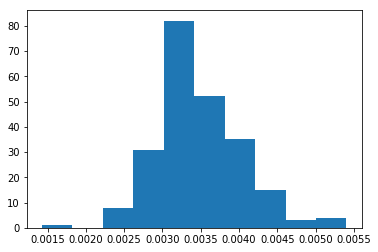

In [22]:
import matplotlib.pyplot as plt

plt.hist([book["average_frequency"] for book in books.values()], bins=10)
plt.show()